# 1. naloga

## Točka b)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t

data = pd.read_csv('17_sem_nal_Izak_Jenko/Kibergrad.csv')
pd.options.display.max_rows = 15

In [2]:
# b) Stratumi
N = data['DOHODEK'].count()

# najprej je treba izračunati proporcionalno alokacijo

# velikost stratumov
N_strat = [data[data['CETRT'] == i]['DOHODEK'].count() for i in range(1,5)]
# n_strat = [vzorec[vzorec['CETRT'] == i]['DOHODEK'].count() for i in range(1,5)]
W = [N_i/N for N_i in N_strat]

# populacijska povprečja po stratumih
mu_strat = [data[data['CETRT'] == i]['DOHODEK'].mean() for i in range(1,5)]
mu = data['DOHODEK'].mean()


# populacijske variance po stratumih
sigma2_strat = [
    sum((data[data['CETRT'] == i]['DOHODEK'] - mu_strat[i-1])**2)/N_strat[i-1] for i in range(1,5)
    ]


$$
\sigma^2_l = \frac{1}{N_l}\sum_{j = 1}^{N_l} (x_{lj} - \mu_l)^2
$$

$$
se^2 = \sum_{l = 1}^L W_l^2 \frac{\sigma_l^2}{n_l}\left( 1 - \frac{n_l - 1}{N_l - 1}\right)
$$

In [3]:
# proporcionalana alokacija
n = 400
print([W[i]*n for i in range(4)]) # dve največji vrednosti zaokrožimo navzgor, ostali dve pa navzdol
n_strat = [92, 95, 123, 90]

# sedaj glede na to proporcionalno alokacijo vzorčimo
def stratificiran_vzorec():
    return [data[data['CETRT'] == i].sample(n=n_strat[i-1]) for i in range(1,5)]

# vzorec tako bodisi genereiriamo z ukazom
# vzorec_strat = stratificiran_vzorec()

# ali pa uvozimo že od prej generiran vzorec z ukazom
vzorec_strat = pd.read_csv('vzorec.csv')

[92.50330401494782, 94.69990429749807, 122.65414938704826, 90.14264230050586]


In [4]:
# če želimo vzorec s katerim s ukvarjamo exportat, poženemo naslednji dve vrstici
# vzorec = pd.concat(vzorec_strat)
# vzorec.to_csv('vzorec.csv', index=False)

In [5]:
# stratumska povprečja vzorca (ocena za stratumska povprečja celotne popoulacije mu_strat)
X_bar_strat = [sum(vzorec_strat[vzorec_strat['CETRT'] == i+1]['DOHODEK'])/n_strat[i] for i in range(4)]
# ta povprečja so med seboj neodvisna, saj sta poljubni dve meritvi iz vzorca, 
# ki prihajata iz različnih stratumov, neodvinsi

# ocena za mu
X_bar_s = sum(W[i]*X_bar_strat[i] for i in range(4))

# stratificirana standardna napaka = sqrt(var(X_bar_s))
se = np.sqrt(
    sum(
        (W[l]**2) * sigma2_strat[l] * (1 - (n_strat[l] - 1)/(N_strat[l] - 1)) / n_strat[l] for l in range(4)
    )
)

# ocena standardne napake 
s2_strat = [
    sum((vzorec_strat[vzorec_strat['CETRT'] == l+1]['DOHODEK'] - X_bar_strat[l])**2)/(n_strat[l] - 1) for l in range(4)
]

se_hat = np.sqrt(
    sum(W[l]**2 * s2_strat[l] * (1 - n_strat[l]/N_strat[l]) / n_strat[l] for l in range(4))
)

In [6]:
# interval zaupanja

# stopnja tveganja
alpha = 0.05

# interval zaupanja za populacijsko povprečje (mu) pod predpostavko, da poznamo 
# populacijsko varianco, torej tocno standardno napako se. 
I_strat = (X_bar_s - se * norm.ppf(1 - alpha/2), X_bar_s + se * norm.ppf(1 - alpha/2))
# Verjetnost, da je mu \in I je 95% pri stopnji tveganja 5%

#dolžina intervala
print(I_strat[1] - I_strat[0])

# (aproksimativni) interval zaupanja za populacijsko povprečje (mu), kadar ne poznamo populacijske 
# variance in namesto tega uporabimo oceno za standardno napako. 
# Ker je velikost vzorca dovolj velika (>100), je uporaba te ocene za standardno napako okej
I_aproks_strat = (X_bar_s - se_hat * norm.ppf(1 - alpha/2), X_bar_s + se_hat * norm.ppf(1 - alpha/2))

# dolžina aproksimativnega intervala
print(I_aproks_strat[1] - I_aproks_strat[0])


6224.055482753538
5548.836625626107


In [7]:
# poskusimo še z aproksimativnim intervalom zaupanja, ki uporablja studentovo porazdelitev.

ni_hat = se_hat**4 / sum(W[l]**4 * s2_strat[l] / (n_strat[l] * (n_strat[l] - 1)) for l in range(4))

I_student_strat = (X_bar_s - se_hat * t.ppf(1 - alpha/2, ni_hat), X_bar_s + se_hat * t.ppf(1 - alpha/2, ni_hat))

# dolžina Studentovega aproksimativnega intevala
print(I_student_strat[1] - I_student_strat[0])

5548.836627815399


Po primerjanju dolžin intervalov zaupanja pri stratificiranem in pri nestratificiranem modelu opazimo, da so vsi intervali zaupanja pri stratificiranem modelu krajši, kar je za napovedovanje boljše! 

In [8]:
def test(st_vzorecev):
    counter = 0
    for i in range(st_vzorecev):
        vzorec_strat = stratificiran_vzorec()
        X_bar_strat = [sum(vzorec_strat[i]['DOHODEK'])/n_strat[i] for i in range(4)]
        X_bar_s = sum(W[i]*X_bar_strat[i] for i in range(4))
        s2_strat = [
            sum((vzorec_strat[l]['DOHODEK'] - X_bar_strat[l])**2)/(n_strat[l] - 1) for l in range(4)
        ]
        se_hat = np.sqrt(
            sum(W[l]**2 * s2_strat[l] * (1 - n_strat[l]/N_strat[l]) / n_strat[l] for l in range(4))
        )

        I = pd.Interval(X_bar_s - se_hat * norm.ppf(1 - alpha/2), X_bar_s + se_hat * norm.ppf(1 - alpha/2))
        if mu in I:
            counter += 1
    return counter

test(st_vzorecev=100)

95

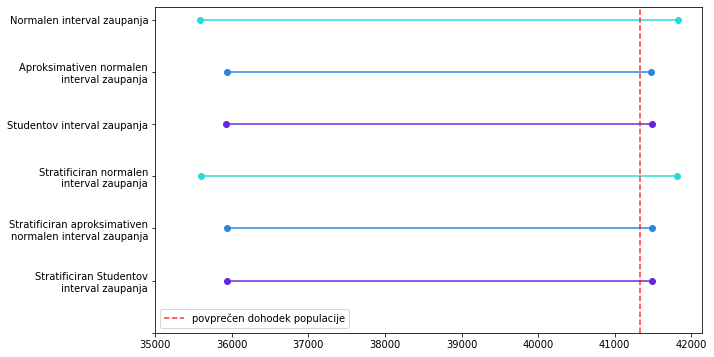

In [9]:
%store -r I
%store -r I_aproks
%store -r I_student

interval_dict = dict()
interval_dict['interval'] = [
    'Normalen interval zaupanja', 
    'Aproksimativen normalen\ninterval zaupanja', 
    'Studentov interval zaupanja',
    'Stratificiran normalen\ninterval zaupanja', 
    'Stratificiran aproksimativen\nnormalen interval zaupanja',
    'Stratificiran Studentov\ninterval zaupanja' 
]
interval_dict['lower'] = [I[0], I_aproks[0], I_student[0], I_strat[0], I_aproks_strat[0], I_student_strat[0]]
interval_dict['upper'] = [I[1], I_aproks[1], I_student[1], I_strat[1], I_aproks_strat[1], I_student_strat[1]]

intervals = pd.DataFrame(interval_dict)

fig = plt.figure(1, figsize=(10,6))
fig.subplots_adjust(left=0.22, right=0.98)
ax = fig.add_subplot(111)
colors = ['#26DCD6','#6526DC','#2687DC',]
for lower, upper, y in zip(intervals['lower'], intervals['upper'], range(len(intervals),0,-1)):
    ax.plot((lower,upper), (y+1,y+1), 'ro-', color=colors[y % 3])
ax.set_yticks(range(len(intervals)+1,0,-1))
ax.set_yticklabels(intervals.interval)
ax.set_xticks(range(35000, 43000, 1000))
ax.axvline(x=mu, c='r', alpha=0.8, ls='--', label='povprečen dohodek populacije')
ax.legend(loc='lower left')

# plt.savefig('intervali_zaupanja.pdf')